In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_clusters = np.loadtxt('all_clusters.txt')
all_labs = np.loadtxt('all_labs.txt')
all_labs_cp = np.loadtxt('all_labs_cleaned.txt')
print(all_clusters.shape, all_labs.shape, all_labs_cp.shape)

(694764, 7) (694764,) (694764,)


In [3]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [4]:
train_x = all_clusters[all_labs_cp!=-1.]
train_y = all_labs_cp[all_labs_cp!=-1.]
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
print(train_x.shape, train_y.shape)
print(train_x[:-10], train_y[:-10])

torch.Size([692025, 7]) torch.Size([692025])
tensor([[ 4.0648e+03, -2.7429e+03,  1.2167e+03,  ..., -4.3054e-02,
          9.6931e-01,  1.3692e+00],
        [ 3.6843e+03, -2.3622e+03,  1.9273e+03,  ..., -7.9827e-01,
         -3.1993e-01,  1.3483e+00],
        [ 3.1204e+03, -1.9099e+03,  2.0164e+03,  ...,  3.5223e-01,
         -7.4458e-01,  1.1130e+00],
        ...,
        [ 5.1271e+03, -1.7017e+03,  2.6256e+02,  ...,  5.5524e-01,
          6.4732e-01,  4.9876e+00],
        [ 6.6652e+03, -1.7857e+03, -4.6316e+02,  ..., -3.1334e-01,
          9.3084e-01,  2.7688e+00],
        [ 5.3990e+03, -2.8705e+03, -2.5322e+03,  ..., -4.4718e-01,
         -8.5641e-01,  1.7896e+00]], dtype=torch.float64) tensor([ 0.,  0.,  0.,  ..., 11., 11., 11.], dtype=torch.float64)


In [5]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# test_dataset = TensorDataset(test_x, test_y)
# test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [68]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = train_x[::1000, :]
print(inducing_points.shape)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

torch.Size([693, 7])


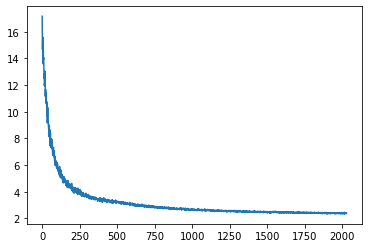

In [70]:
num_epochs = 3

model.train()
likelihood.train()

optimizer = torch.optim.Adam(
    [{'params': model.parameters()},
    {'params': likelihood.parameters()},],
    lr=0.02,
)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

losses = []
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        model.double()
        x_batch = x_batch.double()
        y_batch = y_batch.double()
        output = model(x_batch)
        likelihood.double()
        loss = -mll(output, y_batch)
        losses.append(loss)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        
plt.plot(losses)
plt.show()

In [72]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
with torch.no_grad():
    for x_batch, y_batch in train_loader:
        model.double()
        x_batch = x_batch.double()
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])
means = means[1:]
print('Test MAE: {}'.format(torch.mean(torch.abs(means - train_y.cpu()))))

Test MAE: 3.5571506306499776


In [ ]:
# SVGP https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html
# SVGP CLass https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html
# DKL Multiclass https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html
# Exact Dirichlet https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html?highlight=dirichlet

# https://github.com/cornellius-gp/gpytorch/issues/1396